# **Setup**

## 1) Loading Data and Packages

In [1]:
import os
from google.colab import files
import shutil
import pickle

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [3]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')

In [4]:
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')

In [5]:
adh_data = pd.read_csv('/content/data/adh.csv')

In [6]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']

## 2) Analyzing + Transforming Data

Preliminary setup

In [7]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)

One hot encode

In [8]:
# One hot encode
fitbit_data = pd.get_dummies(
    fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

all_fitbit_data = pd.get_dummies(
    all_fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

In [ ]:
fitbit_data_w_visits = fitbit_data[fitbit_data['visit_day'] == 1].reset_index(drop=True)
fitbit_data_w_visits

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day
0,921,2021-08-31,App Money,7,NaN,2305.0,102.0,2609.0,NaN,NaN,NaN,462.0,46.0,21,ED,0.0,1.0
1,950,2021-09-29,App Money,7,NaN,1898.0,NaN,915.0,NaN,NaN,NaN,NaN,NaN,50,ED to admit,0.0,1.0
2,959,2021-10-08,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,59,ED to admit,0.0,1.0
3,991,2021-11-09,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,91,admission,0.0,1.0
4,1020,2021-12-08,App Money,7,NaN,2379.0,96.0,2210.0,NaN,NaN,NaN,NaN,NaN,120,ED,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,40015,2024-05-26,No App,272,NaN,1055.0,NaN,802.0,NaN,NaN,NaN,NaN,NaN,55,ED to admit,0.0,1.0
76,40024,2024-06-04,No App,272,NaN,1832.0,88.0,14633.0,NaN,NaN,NaN,NaN,NaN,64,ED,0.0,1.0
77,41361,2024-09-19,App Money,279,161.819108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141,admission,0.0,1.0
78,41632,2024-07-07,App Money,284,241.626352,2584.0,76.0,2694.0,1.0,2.0,0.0,122.0,17.0,52,admission,0.0,1.0


In [ ]:
(all_fitbit_data.isna().sum() / len(all_fitbit_data)).sort_values(ascending=False)

,0
admit_type,0.998371
death,0.998215
br_breathingRate,0.826171
temp/skin_nightlyRelative,0.804328
hrv_dailyRmssd,0.769389
hrv_deepRmssd,0.769389
spo2_max,0.744489
spo2_min,0.744489
spo2_avg,0.744489
minutes_awake,0.314993


In [ ]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
fitbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               44820 non-null  int64         
 1   date                     44820 non-null  datetime64[ns]
 2   study_group              44820 non-null  object        
 3   fitbit_user_id           44820 non-null  int64         
 4   avgWeight_per_day        32886 non-null  float64       
 5   calories                 41396 non-null  float64       
 6   heart                    34401 non-null  float64       
 7   steps                    41358 non-null  float64       
 8   minutes_asleep           30702 non-null  float64       
 9   minutes_awake            30702 non-null  float64       
 10  days                     44820 non-null  int64         
 11  admit_type               73 non-null     object        
 12  death                    80 non-

In [ ]:
fitbit_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,days,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,30702.000000,30702.000000,44820.000000,...,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,383.079734,54.538662,89.500000,...,0.360018,0.471307,0.004462,0.019835,0.504507,0.471196,0.357854,0.156917,0.014123,0.471107
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,317.250000,36.000000,44.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,391.000000,53.000000,89.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,457.000000,70.000000,134.250000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,1545.000000,435.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,126.255121,29.144155,51.961302,...,0.480011,0.499182,0.066652,0.139434,0.499985,0.499175,0.479374,0.363726,0.118000,0.499170


In [ ]:
fitbit_data[target_col]

,visit_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
44815,0.0
44816,0.0
44817,0.0
44818,0.0


In [ ]:
fitbit_data[measure_features + one_h_feaatures + [target_col]].corr()

,avgWeight_per_day,calories,heart,steps,diet_response_0.0,diet_response_1.0,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan,visit_day
avgWeight_per_day,1.000000,0.373354,0.129531,-0.144976,-0.012775,0.115264,0.037072,-0.116215,0.026173,0.037068,0.100517,-0.116188,0.037277,0.057270,0.128357,-0.115703,-0.000209
calories,0.373354,1.000000,-0.023124,0.456305,-0.022520,0.036252,-0.007507,-0.009382,-0.001204,0.008699,0.006654,-0.009054,0.047490,-0.054580,0.015333,-0.009188,-0.015476
heart,0.129531,-0.023124,1.000000,-0.173048,-0.033483,0.015795,0.039888,-0.037826,0.033239,0.069086,0.012165,-0.038015,-0.024675,0.060177,0.062618,-0.037960,0.014878
steps,-0.144976,0.456305,-0.173048,1.000000,-0.014462,0.004755,0.038059,-0.035000,-0.014207,-0.012302,0.040083,-0.034741,0.138243,-0.112696,-0.063136,-0.035018,-0.030752
diet_response_0.0,-0.012775,-0.022520,-0.033483,-0.014462,1.000000,-0.075231,-0.143982,-0.181251,0.055853,0.091097,0.148067,-0.181211,0.072133,0.143803,0.028087,-0.180695,-0.002408
diet_response_1.0,0.115264,0.036252,0.015795,0.004755,-0.075231,1.000000,-0.293930,-0.370012,0.027959,0.118060,0.331891,-0.369140,0.259858,0.162634,0.005971,-0.369469,-0.005680
diet_response_2.0,0.037072,-0.007507,0.039888,0.038059,-0.143982,-0.293930,1.000000,-0.708156,0.024406,0.020650,0.697280,-0.707438,0.519989,0.252394,0.102067,-0.707405,-0.015198
diet_response_nan,-0.116215,-0.009382,-0.037826,-0.035000,-0.181251,-0.370012,-0.708156,1.000000,-0.063212,-0.133992,-0.951290,0.998702,-0.703621,-0.406719,-0.112628,0.998702,0.019373
medication_response_0.0,0.026173,-0.001204,0.033239,-0.014207,0.055853,0.027959,0.024406,-0.063212,1.000000,-0.009524,-0.067556,-0.063198,0.010076,0.053948,0.060072,-0.063187,0.005099
medication_response_1.0,0.037068,0.008699,0.069086,-0.012302,0.091097,0.118060,0.020650,-0.133992,-0.009524,1.000000,-0.143542,-0.134282,0.040013,0.120324,0.034505,-0.134258,0.001566


Missingness in columns

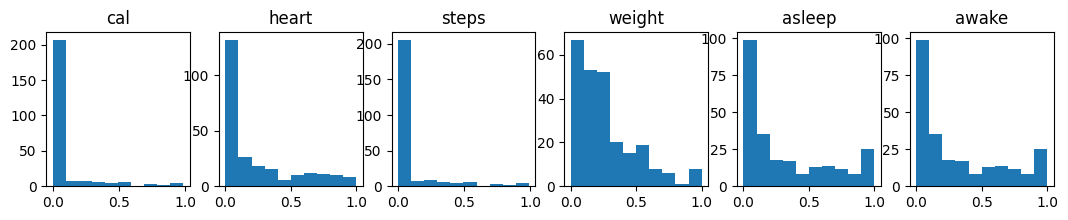

In [ ]:
cal = []
heart = []
steps = []
weight = []
asleep = []
awake = []
for i in all_fitbit_data['fitbit_user_id'].unique():
    temp = all_fitbit_data[all_fitbit_data['fitbit_user_id']==i].reset_index(drop=True)
    cal += [temp['calories'].isna().sum()/len(temp)]
    heart += [temp['heart'].isna().sum()/len(temp)]
    steps += [temp['steps'].isna().sum()/len(temp)]
    weight += [temp['avgWeight_per_day'].isna().sum()/len(temp)]
    asleep += [temp['minutes_asleep'].isna().sum()/len(temp)]
    awake += [temp['minutes_awake'].isna().sum()/len(temp)]

fig, axs = plt.subplots(1,6,figsize=(13,2))
axs[0].hist(cal)
axs[0].set_title('cal')
axs[1].hist(heart)
axs[1].set_title('heart')
axs[2].hist(steps)
axs[2].set_title('steps')
axs[3].hist(weight)
axs[3].set_title('weight')
axs[4].hist(asleep)
axs[4].set_title('asleep')
axs[5].hist(awake)
axs[5].set_title('awake')
plt.show()

*   weight, sleep numbers are missing alot

See how many weeks/days should be removed given too many missing values

In [ ]:
def windows_to_remove(df, features, max_nans = 3, window_days = 7):

  drop = 0
  count = 0

  for _,group in df.groupby('fitbit_user_id'):
    group = group.copy()

    for i in range(0, len(group), window_days):
      window = group.iloc[i:i+window_days]

      for feature in features:
        nan_count = window[feature].isna().sum()
        if nan_count >= max_nans:
          drop += 1
          break

      count += 1

  keep = count - drop

  return count, keep, drop

count, keep, drop = windows_to_remove(fitbit_data, measure_features)

keep/count

0.7567191844300278

## 3) Imputation and Sequence Creation

### 3a) With Imputation

In [9]:
def fix_nans(df, features, max_nans=3, window_days=7):
    df = df.copy()
    cleaned_data = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy().reset_index(drop=True)
        feature_values = {feature: [] for feature in features}

        for i in range(0, len(group), window_days):
            window = group.iloc[i:i+window_days].copy()
            drop_window = False

            for feature in features:
                nan_count = window[feature].isna().sum()
                if nan_count >= max_nans:
                    drop_window = True

                for j in range(len(window)):
                    val = window.iloc[j][feature]
                    if pd.notna(val):
                        feature_values[feature].append(val)
                    else:
                        if len(feature_values[feature]) == 0:
                            drop_window = True
                        else:
                            mean_val = float(np.mean(feature_values[feature]))
                            feature_values[feature].append(mean_val)
                            window.loc[window.index[j], feature] = mean_val

            if not drop_window:
                cleaned_data.append(window)

    result_df = pd.concat(cleaned_data, ignore_index=True)
    return result_df

In [40]:
def create_sequences_imputation(df, sequence_len=7, visit_label='sequence'):
    fitbit_seq_dicts = {}

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.copy().reset_index(drop=True)
        sequences = {}
        has_visit = False

        # For 'study' level, determine once per user
        if visit_label == 'study':
            has_visit = int((group['visit_day'] != 0).any())

        for i in range(0, len(group), sequence_len):
            week_df = group.iloc[i:i+sequence_len].copy()

            if visit_label == 'sequence':
                has_visit = int((week_df['visit_day'] != 0).any())

            sequences[i] = (week_df[measure_features], has_visit)

        fitbit_seq_dicts[user_id] = sequences

    return fitbit_seq_dicts

In [47]:
imputed_fb_data = fix_nans(fitbit_data, measure_features)
fitbit_seq_dicts_study_level = create_sequences_imputation(imputed_fb_data, visit_label='study')
fitbit_seq_dicts_sequence_level = create_sequences_imputation(imputed_fb_data, visit_label='sequence')

In [33]:
fitbit_seq_dicts_sequence_level[1]

{0: (    calories  heart    steps
  0     2879.0   66.0   6260.0
  1     3207.0   66.0  10805.0
  2     2911.0   67.0   8292.0
  3     3301.0   66.0   8250.0
  4     3106.0   66.0   7704.0
  5     2644.0   66.0   3785.0
  6     3576.0   66.0  14518.0
  7     2849.0   66.0   5894.0
  8     2894.0   66.0   5745.0
  9     2402.0   65.0   3200.0
  10    2876.0   65.0   5741.0
  11    2812.0   65.0   5601.0
  12    3558.0   65.0  10427.0
  13    2854.0   65.0   5280.0,
  0),
 14: (    calories  heart    steps
  14    3107.0   65.0   6257.0
  15    3054.0   66.0   9497.0
  16    2786.0   66.0   6697.0
  17    2777.0   65.0   5639.0
  18    3235.0   65.0   9050.0
  19    2991.0   67.0   7342.0
  20    2891.0   66.0   6066.0
  21    2788.0   65.0   5756.0
  22    2902.0   65.0   8353.0
  23    2483.0   65.0   4413.0
  24    2376.0   65.0   2453.0
  25    2879.0   64.0   6087.0
  26    3884.0   64.0  12317.0
  27    3010.0   65.0   7392.0,
  0),
 28: (    calories  heart    steps
  28    3254.0

In [48]:
# Save/download pkl files

with open("fitbit_seq_dicts_impute_study_7.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_study_level, f)

with open("fitbit_seq_dicts_impute_sequence_7.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_sequence_level, f)

files.download("fitbit_seq_dicts_impute_study_7.pkl")
files.download("fitbit_seq_dicts_impute_sequence_7.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3b) Without Imputation

In [10]:
def create_sequences_no_imputation(df, sequence_len=7, visit_label='sequence'):
    fitbit_seq_dicts = {}

    for user_id, group in tqdm(df.groupby('fitbit_user_id')):
        group = group.copy().reset_index(drop=True)
        sequences = {}
        has_visit = False

        # For 'study' level, determine once per user
        if visit_label == 'study':
            has_visit = int((group['visit_day'] != 0).any())

        for i in range(0, len(group), sequence_len):
            week_df = group.iloc[i:i+sequence_len].copy()

            if visit_label == 'sequence':
                has_visit = int((week_df['visit_day'] != 0).any())

            sequences[i] = (week_df[all_features], has_visit)

        fitbit_seq_dicts[user_id] = sequences

    return fitbit_seq_dicts

In [11]:
def clean_nans(fb_dict, thresh):
  ''' Clean dict that contain mostly missing values based on threshold.
      thresh is allowed perecent of missing values '''
  max_nan = int(thresh * len(fb_dict))

  clean_dict = {}

  for user_id, seq_dict in tqdm(fb_dict.items()):
    clean_dict_user_id = {}

    for dict_window, feature_label_tuple in seq_dict.items():
      seq, label = feature_label_tuple

      nan_count = seq.isna().sum().sum() # sum of nans in each column, summed once again

      if nan_count < max_nan:
        clean_dict_user_id[dict_window] = (seq, label)

    clean_dict[user_id] = clean_dict_user_id

  return clean_dict


In [12]:
def calc_visits(my_dict):
    total_visits = 0
    for k,v in my_dict.items():
        for kk, vv in v.items():
            if vv[1] == 1:
                total_visits += 1
    return total_visits

In [13]:
seq_noimp_7 = create_sequences_no_imputation(all_fitbit_data, 7, visit_label='sequence')
study_noimp_7 = create_sequences_no_imputation(all_fitbit_data, 7, visit_label='study')
seq_noimp_14 = create_sequences_no_imputation(all_fitbit_data, 14, visit_label='sequence')
study_noimp_14 = create_sequences_no_imputation(all_fitbit_data, 14, visit_label='study')

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

In [14]:
fitbit_seq_dicts_sequence_7 = clean_nans(seq_noimp_7, 0.7)
fitbit_seq_dicts_study_7 = clean_nans(study_noimp_7, 0.7)
fitbit_seq_dicts_sequence_14 = clean_nans(seq_noimp_14, 0.7)
fitbit_seq_dicts_study_14 = clean_nans(study_noimp_14, 0.7)

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

In [15]:
# Save/download pkl files

with open("fitbit_seq_dicts_sequence_7.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_sequence_7, f)

with open("fitbit_seq_dicts_study_7.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_study_7, f)

with open("fitbit_seq_dicts_sequence_14.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_sequence_14, f)

with open("fitbit_seq_dicts_study_14.pkl", "wb") as f:
    pickle.dump(fitbit_seq_dicts_study_14, f)

files.download("fitbit_seq_dicts_sequence_7.pkl")
files.download("fitbit_seq_dicts_study_7.pkl")
files.download("fitbit_seq_dicts_sequence_14.pkl")
files.download("fitbit_seq_dicts_study_14.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>